<a href="https://colab.research.google.com/github/MarcosVeniciu/AEDs/blob/master/clusterizacaoprodutores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def grafico_contagem(df, coluna_contagem):
    # Cria uma cópia da coluna especificada para evitar alterar o DataFrame original
    coluna = df[coluna_contagem].copy()

    # Garantir que a coluna especificada esteja no formato datetime, se for uma data
    if pd.api.types.is_datetime64_any_dtype(coluna):
        coluna = pd.to_datetime(coluna)

    # Extrair o ano da coluna, caso seja uma coluna de datas
    if 'datetime' in str(coluna.dtype):
        coluna = coluna.dt.year

    # Contar as ocorrências de cada ano ou valor
    ano_contagem = coluna.value_counts().sort_index()

    # Gerar cores aleatórias e distintas para cada barra
    np.random.seed(0)  # Para consistência das cores ao rodar novamente
    cores = plt.cm.tab20(np.linspace(0, 1, len(ano_contagem)))  # Usa um mapa de cores com tons bem distintos

    # Plotar o gráfico de barras com cores específicas
    plt.figure(figsize=(10, 6))
    ano_contagem.plot(kind='bar', color=cores)

    # Adicionar título e rótulos
    plt.title(f'Número de Ocorrências por {coluna_contagem}')
    plt.xlabel(coluna_contagem)
    plt.ylabel('Contagem')

    # Adicionar grades
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Rotacionar rótulos do eixo X
    plt.xticks(rotation=45)

    # Ajustar o layout para garantir que tudo fique visível
    plt.tight_layout()

    # Mostrar o gráfico
    plt.show()


# Preparação Dataset

Os dados do rebanho estão no dataset rebanho. E o tipo de sistema produtivo do produtor esta no taxas_anuais. O objetivo é ter um modelo para cada sitema produtivo. \
O dataset é filtrado por sistema produtivo, então em produtores tem a lista de todos os produtores do sistema produtivo buscado e o df_rebanho_produtores tem os dados dos rebanhos de cada produto do sistema produtivo usado.

In [3]:
df_rebanho = pd.read_excel("rebanho.xlsx")
df_rebanho["Ano"] = df_rebanho['Mes'].apply(lambda x: x.strftime('%Y'))
df_rebanho["Mes"] = df_rebanho['Mes'].apply(lambda x: x.strftime('%m'))

In [4]:
df_taxas_anuais = pd.read_excel("taxas_anuais.xlsx")

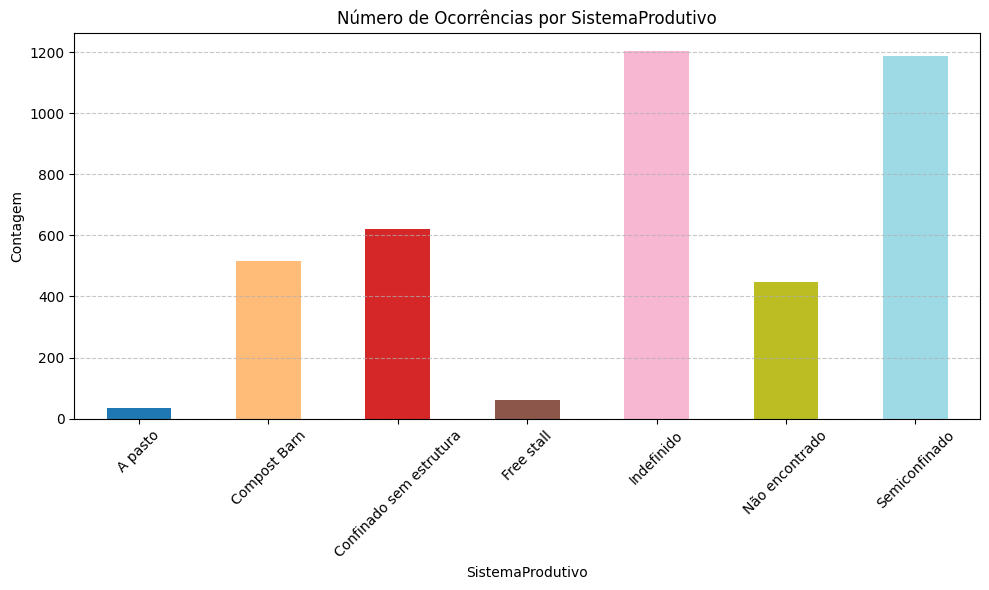

In [5]:
grafico_contagem(df_taxas_anuais, "SistemaProdutivo")

In [6]:
ano_referencia = "2023"
sistema_produtivo = "Semiconfinado"

In [7]:
# lista de produtores de do sistema produtivo
produtores = df_taxas_anuais.loc[(df_taxas_anuais["SistemaProdutivo"] == sistema_produtivo), "CodFazenda"].unique()
print(f"{len(produtores)} produtores no sistema produtivo {sistema_produtivo}.")

326 produtores no sistema produtivo Semiconfinado.


In [8]:
# lista de rebanho dos produtores filtrados
df_rebanho_produtores = df_rebanho.loc[(df_rebanho["CodFazenda"].isin(produtores))]

In [9]:
def calcula_migracoes(produtor, mes, ano):
    ordem = [
        "Fêmeas 0 - 12 meses em aleitamento",
        "Fêmeas 0 - 12 meses desaleitadas",
        "Fêmeas 12 - 24 meses",
        "Fêmeas 24 - 36 meses",
        "Fêmeas 36 - 48 meses",
        "Vacas Secas",
        "Vacas em Lactação"
    ]

    df_rebanho_produtor_ant = df_rebanho.loc[(df_rebanho["CodFazenda"] == produtor) & (df_rebanho["Ano"] == ano)]

    for categoria in ordem:
        dado_categoria = df_rebanho_produtor_ant.loc[
            (df_rebanho_produtor_ant["Categoria"] == categoria) &
            (df_rebanho_produtor_ant["Mes"] == mes)]
        if categoria == "Fêmeas 0 - 12 meses em aleitamento":
            mF012a_F012d = (dado_categoria["Inicio"].sum() + dado_categoria["Nascimento"].sum() + dado_categoria["Compra"].sum() - dado_categoria["Venda"].sum() - dado_categoria["Morte"].sum()) - dado_categoria["Final"].sum()
        elif categoria == "Fêmeas 0 - 12 meses desaleitadas":
            mF012d_F1224 = (dado_categoria["Inicio"].sum() + dado_categoria["Compra"].sum() - dado_categoria["Venda"].sum() - dado_categoria["Morte"].sum()) + mF012a_F012d - dado_categoria["Final"].sum()
        elif categoria == "Fêmeas 12 - 24 meses":
            mF1224_F2436 = (dado_categoria["Inicio"].sum() + dado_categoria["Compra"].sum() - dado_categoria["Venda"].sum() - dado_categoria["Morte"].sum()) + mF012d_F1224 - dado_categoria["Final"].sum()
        elif categoria == "Fêmeas 24 - 36 meses":
            mF2436 = (dado_categoria["Inicio"].sum() + dado_categoria["Compra"].sum() - dado_categoria["Venda"].sum() - dado_categoria["Morte"].sum()) + mF1224_F2436 - dado_categoria["Final"].sum()
            if mF2436 > 0:
                dado_F3648 = df_rebanho_produtor_ant.loc[
                    (df_rebanho_produtor_ant["Categoria"] == "Fêmeas 36 - 48 meses") &
                    (df_rebanho_produtor_ant["Mes"] == mes)]
                mF2436_VL = mF2436 - abs((dado_F3648["Inicio"].sum() + dado_F3648["Compra"].sum() - dado_F3648["Venda"].sum() - dado_F3648["Morte"].sum()) - dado_F3648["Final"].sum())
                mF2436_F3648 = mF2436 - mF2436_VL
            else:
                mF2436_VL = 0
                mF2436_F3648 = 0
        elif categoria == "Fêmeas 36 - 48 meses":
            mF3648 = (dado_categoria["Inicio"].sum() + dado_categoria["Compra"].sum() - dado_categoria["Venda"].sum() - dado_categoria["Morte"].sum()) + mF2436_F3648 - dado_categoria["Final"].sum()
            if mF3648 > 0:
                dado_VS = df_rebanho_produtor_ant.loc[
                    (df_rebanho_produtor_ant["Categoria"] == "Vacas Secas") &
                    (df_rebanho_produtor_ant["Mes"] == mes)]
                mF3648_VS = mF3648 - abs((dado_VS["Inicio"].sum() + dado_VS["Compra"].sum() - dado_VS["Venda"].sum() - dado_VS["Morte"].sum()) - dado_VS["Final"].sum())
                mF3648_VL = mF3648 - mF3648_VS
            else:
                mF3648_VS = 0
                mF3648_VL = 0
        elif categoria == "Vacas Secas":
            mVS_VL = (dado_categoria["Inicio"].sum() + dado_categoria["Compra"].sum() - dado_categoria["Venda"].sum() - dado_categoria["Morte"].sum()) + mF3648_VS - dado_categoria["Final"].sum()
            if mVS_VL < 0:
                mVS_VL = 0
        else:
            mVL_VS = (dado_categoria["Inicio"].sum() + dado_categoria["Compra"].sum() - dado_categoria["Venda"].sum() - dado_categoria["Morte"].sum()) + mF2436_VL + mF3648_VL + mVS_VL - dado_categoria["Final"].sum()

    migracoes = {
        "mF012a_F012d": mF012a_F012d,
        "mF012d_F1224": mF012d_F1224,
        "mF1224_F2436": mF1224_F2436,
        "mF2436_VL": mF2436_VL,
        "mF2436_F3648": mF2436_F3648,
        "mF3648_VS": mF3648_VS,
        "mF3648_VL": mF3648_VL,
        "mVS_VL": mVS_VL,
        "mVL_VS": mVL_VS
    }

    return migracoes

### Tentativa 1

In [10]:
def build_dataset(produtor):
    anos_produtor = df_rebanho.loc[(df_rebanho["CodFazenda"] == produtor), "Ano"].unique()
    anos_produtor = anos_produtor.tolist()

    if "2019" in anos_produtor:
        anos_produtor.remove("2019")
    if "2024" in anos_produtor:
        anos_produtor.remove("2024")
    if "2023" in anos_produtor:
        anos_produtor.remove("2023")

    meses_dos_anos = []
    nascimentos_dos_anos = []
    for ano in anos_produtor:
        for i in range(12):
            meses_dos_anos.append("{:02d}/{}".format(i+1, ano))

        dados_do_ano = df_rebanho.loc[(df_rebanho["CodFazenda"] == produtor) & (df_rebanho["Ano"] == ano)]
        nascimentos_f = dados_do_ano.loc[
            (dados_do_ano["Categoria"] == 'Fêmeas 0 - 12 meses em aleitamento'),
            "Nascimento"].to_numpy()
        nascimentos_m = dados_do_ano.loc[
            (dados_do_ano["Categoria"] == 'Machos 0 - 12 meses em aleitamento'),
            "Nascimento"].to_numpy()
        nascimentos_do_ano = nascimentos_f + nascimentos_m
        nascimentos_dos_anos += nascimentos_do_ano.tolist()

    if len(nascimentos_dos_anos) != 36:
        return None

    df_data = pd.DataFrame(columns=[
        "CodFazenda",
        "Mes",
        "Secagens_10",
        "Secagens_11",
        "Secagens_12",
        "Secagens_13",
        "Secagens_14",
        "Secagens_15",
        "Nascimento"
    ])

    secagens_10_antes = []
    secagens_11_antes = []
    secagens_12_antes = []
    secagens_13_antes = []
    secagens_14_antes = []
    secagens_15_antes = []


    for mes_ano in meses_dos_anos:
        mes = mes_ano.split("/")[0]
        ano = mes_ano.split("/")[1]

        if mes_ano == '01/2020':
            secagens_10_antes.append(0)
            secagens_11_antes.append(0)
            secagens_12_antes.append(0)
            secagens_13_antes.append(0)
            secagens_14_antes.append(0)
            secagens_15_antes.append(0)
        elif mes_ano == '02/2020':
            if int(mes) < 11:
                migracoes_10 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-10+12), str(int(ano)-1))
            else:
                migracoes_10 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-10), ano)
            secagens_10_antes.append(migracoes_10["mVL_VS"])

            secagens_11_antes.append(0)
            secagens_12_antes.append(0)
            secagens_13_antes.append(0)
            secagens_14_antes.append(0)
            secagens_15_antes.append(0)
        elif mes_ano == '03/2020':
            if int(mes) < 11:
                migracoes_10 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-10+12), str(int(ano)-1))
            else:
                migracoes_10 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-10), ano)
            secagens_10_antes.append(migracoes_10["mVL_VS"])

            if int(mes) < 12:
                migracoes_11 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-11+12), str(int(ano)-1))
            else:
                migracoes_11 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-11), ano)
            secagens_11_antes.append(migracoes_11["mVL_VS"])

            secagens_12_antes.append(0)
            secagens_13_antes.append(0)
            secagens_14_antes.append(0)
            secagens_15_antes.append(0)
        elif mes_ano == '04/2020':
            if int(mes) < 11:
                migracoes_10 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-10+12), str(int(ano)-1))
            else:
                migracoes_10 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-10), ano)
            secagens_10_antes.append(migracoes_10["mVL_VS"])

            if int(mes) < 12:
                migracoes_11 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-11+12), str(int(ano)-1))
            else:
                migracoes_11 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-11), ano)
            secagens_11_antes.append(migracoes_11["mVL_VS"])

            migracoes_12 = calcula_migracoes(produtor, mes, str(int(ano)-1))
            secagens_12_antes.append(migracoes_12["mVL_VS"])

            secagens_13_antes.append(0)
            secagens_14_antes.append(0)
            secagens_15_antes.append(0)
        elif mes_ano == '05/2020':
            if int(mes) < 11:
                migracoes_10 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-10+12), str(int(ano)-1))
            else:
                migracoes_10 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-10), ano)
            secagens_10_antes.append(migracoes_10["mVL_VS"])

            if int(mes) < 12:
                migracoes_11 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-11+12), str(int(ano)-1))
            else:
                migracoes_11 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-11), ano)
            secagens_11_antes.append(migracoes_11["mVL_VS"])

            migracoes_12 = calcula_migracoes(produtor, mes, str(int(ano)-1))
            secagens_12_antes.append(migracoes_12["mVL_VS"])

            if int(mes) < 2:
                migracoes_13 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-13+24), str(int(ano)-2))
            else:
                migracoes_13 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-13+12), str(int(ano)-1))
            secagens_13_antes.append(migracoes_13["mVL_VS"])

            secagens_14_antes.append(0)
            secagens_15_antes.append(0)
        elif mes_ano == '06/2020':
            if int(mes) < 11:
                migracoes_10 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-10+12), str(int(ano)-1))
            else:
                migracoes_10 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-10), ano)
            secagens_10_antes.append(migracoes_10["mVL_VS"])

            if int(mes) < 12:
                migracoes_11 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-11+12), str(int(ano)-1))
            else:
                migracoes_11 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-11), ano)
            secagens_11_antes.append(migracoes_11["mVL_VS"])

            migracoes_12 = calcula_migracoes(produtor, mes, str(int(ano)-1))
            secagens_12_antes.append(migracoes_12["mVL_VS"])

            if int(mes) < 2:
                migracoes_13 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-13+24), str(int(ano)-2))
            else:
                migracoes_13 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-13+12), str(int(ano)-1))
            secagens_13_antes.append(migracoes_13["mVL_VS"])

            if int(mes) < 3:
                migracoes_14 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-14+24), str(int(ano)-2))
            else:
                migracoes_14 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-14+12), str(int(ano)-1))
            secagens_14_antes.append(migracoes_14["mVL_VS"])

            secagens_15_antes.append(0)
        else:
            # 10 meses antes
            if int(mes) < 11:
                migracoes_10 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-10+12), str(int(ano)-1))
            else:
                migracoes_10 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-10), ano)
            secagens_10_antes.append(migracoes_10["mVL_VS"])

            # 11 meses antes
            if int(mes) < 12:
                migracoes_11 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-11+12), str(int(ano)-1))
            else:
                migracoes_11 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-11), ano)
            secagens_11_antes.append(migracoes_11["mVL_VS"])

            # 12 meses antes
            migracoes_12 = calcula_migracoes(produtor, mes, str(int(ano)-1))
            secagens_12_antes.append(migracoes_12["mVL_VS"])

            # 13 meses antes
            if int(mes) < 2:
                migracoes_13 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-13+24), str(int(ano)-2))
            else:
                migracoes_13 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-13+12), str(int(ano)-1))
            secagens_13_antes.append(migracoes_13["mVL_VS"])

            # 14 meses antes
            if int(mes) < 3:
                migracoes_14 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-14+24), str(int(ano)-2))
            else:
                migracoes_14 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-14+12), str(int(ano)-1))
            secagens_14_antes.append(migracoes_14["mVL_VS"])

            # 15 meses antes
            if int(mes) < 4:
                migracoes_15 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-15+24), str(int(ano)-2))
            else:
                migracoes_15 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-15+12), str(int(ano)-1))
            secagens_15_antes.append(migracoes_15["mVL_VS"])

    df_data["Secagens_10"] = secagens_10_antes
    df_data["Secagens_11"] = secagens_11_antes
    df_data["Secagens_12"] = secagens_12_antes
    df_data["Secagens_13"] = secagens_13_antes
    df_data["Secagens_14"] = secagens_14_antes
    df_data["Secagens_15"] = secagens_15_antes

    df_data["Nascimento"] = nascimentos_dos_anos
    df_data["CodFazenda"] = produtor
    df_data["Mes"] = [mes.replace("/", "-") for mes in meses_dos_anos]
    df_data["Mes"] = pd.to_datetime(df_data.Mes, format="%m-%Y")
    df_data = df_data.set_index(df_data.Mes)
    #df_data.drop('Mes', axis=1, inplace=True)
    df_data.index = pd.DatetimeIndex(df_data.index.values, freq=df_data.index.inferred_freq)

    return df_data

In [11]:
df_train = pd.DataFrame()

#for produtor in produtores:
for produtor in tqdm(produtores, desc="Processando produtores"):
  df_produtor_2020 = df_rebanho_produtores.loc[(df_rebanho_produtores["CodFazenda"] == produtor) & (df_rebanho_produtores["Ano"] == "2020")]
  df_produtor_2021 = df_rebanho_produtores.loc[(df_rebanho_produtores["CodFazenda"] == produtor) & (df_rebanho_produtores["Ano"] == "2021")]
  df_produtor_2022 = df_rebanho_produtores.loc[(df_rebanho_produtores["CodFazenda"] == produtor) & (df_rebanho_produtores["Ano"] == "2022")]

  if not df_produtor_2020.empty and not df_produtor_2021.empty and not df_produtor_2022.empty:
    df_data_produtor = build_dataset(produtor)
    if df_data_produtor is not None:
      df_train = pd.concat([df_train, df_data_produtor], ignore_index=True)
print("\n\n")
df_train.info()

Processando produtores: 100%|██████████| 326/326 [1:15:27<00:00, 13.89s/it]




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5904 entries, 0 to 5903
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   CodFazenda   5904 non-null   object        
 1   Mes          5904 non-null   datetime64[ns]
 2   Secagens_10  5904 non-null   int64         
 3   Secagens_11  5904 non-null   int64         
 4   Secagens_12  5904 non-null   int64         
 5   Secagens_13  5904 non-null   int64         
 6   Secagens_14  5904 non-null   int64         
 7   Secagens_15  5904 non-null   int64         
 8   Nascimento   5904 non-null   int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 415.2+ KB


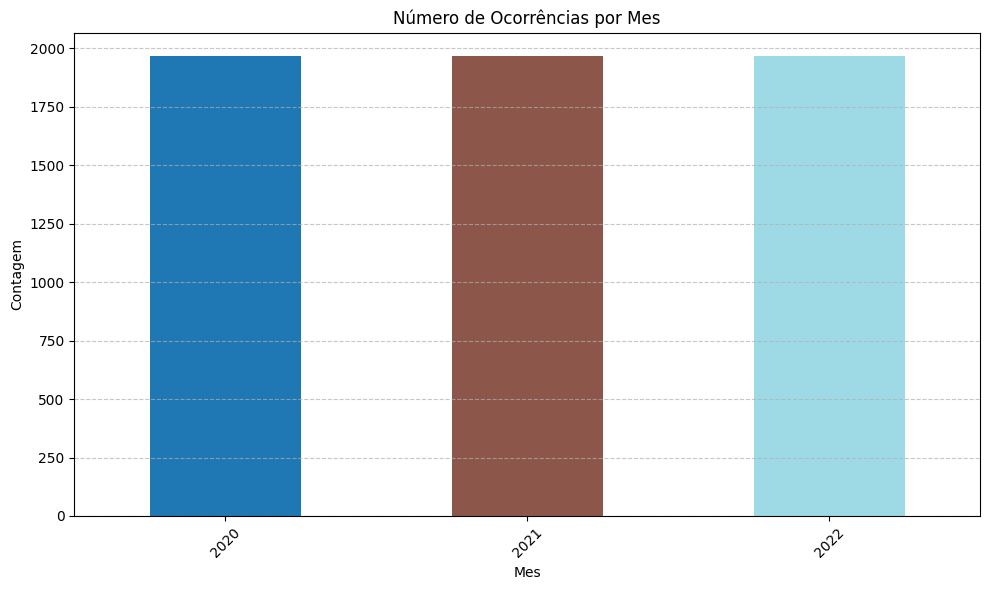

In [12]:
grafico_contagem(df_train, "Mes")

In [14]:
df_train.to_csv("train_data_Semiconfinado.csv", index=False)

In [11]:
def build_2023(produtor):
  meses_dos_anos = []
  nascimentos_2023 = []

  for i in range(12):
      meses_dos_anos.append("{:02d}/{}".format(i+1, 2023))

  dados_do_ano = df_rebanho.loc[(df_rebanho["CodFazenda"] == produtor) & (df_rebanho["Ano"] == "2023")]
  nascimentos_f = dados_do_ano.loc[
      (dados_do_ano["Categoria"] == 'Fêmeas 0 - 12 meses em aleitamento'),
      "Nascimento"].to_numpy()
  nascimentos_m = dados_do_ano.loc[
      (dados_do_ano["Categoria"] == 'Machos 0 - 12 meses em aleitamento'),
      "Nascimento"].to_numpy()
  nascimentos_do_ano = nascimentos_f + nascimentos_m
  nascimentos_2023 += nascimentos_do_ano.tolist()

  if len(nascimentos_2023) != 12:
    return None
  else:
    df_2023 = pd.DataFrame(columns=[
      "CodFazenda",
      "Mes",
      "Secagens_10",
      "Secagens_11",
      "Secagens_12",
      "Secagens_13",
      "Secagens_14",
      "Secagens_15",
      "Nascimento"
    ])

    secagens_10_antes = []
    secagens_11_antes = []
    secagens_12_antes = []
    secagens_13_antes = []
    secagens_14_antes = []
    secagens_15_antes = []

    for mes_ano in meses_dos_anos:
      mes = mes_ano.split("/")[0]
      ano = mes_ano.split("/")[1]

      # 10 meses antes
      if int(mes) < 11:
        migracoes_10 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-10+12), str(int(ano)-1))
      else:
        migracoes_10 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-10), ano)
      secagens_10_antes.append(migracoes_10["mVL_VS"])

      # 11 meses antes
      if int(mes) < 12:
        migracoes_11 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-11+12), str(int(ano)-1))
      else:
        migracoes_11 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-11), ano)
      secagens_11_antes.append(migracoes_11["mVL_VS"])

      # 12 meses antes
      migracoes_12 = calcula_migracoes(produtor, mes, str(int(ano)-1))
      secagens_12_antes.append(migracoes_12["mVL_VS"])

      # 13 meses antes
      if int(mes) < 2:
        migracoes_13 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-13+24), str(int(ano)-2))
      else:
          migracoes_13 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-13+12), str(int(ano)-1))
      secagens_13_antes.append(migracoes_13["mVL_VS"])

      # 14 meses antes
      if int(mes) < 3:
        migracoes_14 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-14+24), str(int(ano)-2))
      else:
        migracoes_14 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-14+12), str(int(ano)-1))
      secagens_14_antes.append(migracoes_14["mVL_VS"])

      # 15 meses antes
      if int(mes) < 4:
        migracoes_15 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-15+24), str(int(ano)-2))
      else:
        migracoes_15 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-15+12), str(int(ano)-1))
      secagens_15_antes.append(migracoes_15["mVL_VS"])


    df_2023["Secagens_10"] = secagens_10_antes
    df_2023["Secagens_11"] = secagens_11_antes
    df_2023["Secagens_12"] = secagens_12_antes
    df_2023["Secagens_13"] = secagens_13_antes
    df_2023["Secagens_14"] = secagens_14_antes
    df_2023["Secagens_15"] = secagens_15_antes

    df_2023["CodFazenda"] = produtor
    df_2023["Nascimento"] = nascimentos_2023
    df_2023["Mes"] = [mes.replace("/", "-") for mes in meses_dos_anos]
    df_2023["Mes"] = pd.to_datetime(df_2023.Mes, format="%m-%Y")
    df_2023 = df_2023.set_index(df_2023.Mes)
    #df_2023.drop('Mes', axis=1, inplace=True)
    df_2023.index = pd.DatetimeIndex(df_2023.index.values, freq=df_2023.index.inferred_freq)

    return df_2023

In [12]:
df_train = pd.read_csv("/content/train_data_Semiconfinado.csv")

In [13]:
df_test = pd.DataFrame()
#for produtor in produtores:
for produtor in tqdm(df_train['CodFazenda'].unique(), desc="Processando produtores"):
    df_data_produtor = build_2023(produtor)
    if df_data_produtor is not None:
      df_test = pd.concat([df_test, df_data_produtor], ignore_index=True)
print("\n\n")
df_test.info()

Processando produtores: 100%|██████████| 164/164 [23:40<00:00,  8.66s/it]




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   CodFazenda   1680 non-null   object        
 1   Mes          1680 non-null   datetime64[ns]
 2   Secagens_10  1680 non-null   int64         
 3   Secagens_11  1680 non-null   int64         
 4   Secagens_12  1680 non-null   int64         
 5   Secagens_13  1680 non-null   int64         
 6   Secagens_14  1680 non-null   int64         
 7   Secagens_15  1680 non-null   int64         
 8   Nascimento   1680 non-null   int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 118.2+ KB


In [15]:
df_test.to_csv("test_data_Semiconfinado.csv", index=False)

### Tentativa para uma segunda versão do dataset

In [10]:
def build_dataset(produtor):
    anos_produtor = df_rebanho.loc[(df_rebanho["CodFazenda"] == produtor), "Ano"].unique()
    anos_produtor = anos_produtor.tolist()

    if "2019" in anos_produtor:
        anos_produtor.remove("2019")
    if "2024" in anos_produtor:
        anos_produtor.remove("2024")

    meses_dos_anos = []
    nascimentos_dos_anos = []
    for ano in anos_produtor:
        for i in range(12):
            meses_dos_anos.append("{:02d}/{}".format(i+1, ano))

        dados_do_ano = df_rebanho.loc[(df_rebanho["CodFazenda"] == produtor) & (df_rebanho["Ano"] == ano)]
        nascimentos_f = dados_do_ano.loc[
            (dados_do_ano["Categoria"] == 'Fêmeas 0 - 12 meses em aleitamento'),
            "Nascimento"].to_numpy()
        nascimentos_m = dados_do_ano.loc[
            (dados_do_ano["Categoria"] == 'Machos 0 - 12 meses em aleitamento'),
            "Nascimento"].to_numpy()
        nascimentos_do_ano = nascimentos_f + nascimentos_m
        nascimentos_dos_anos += nascimentos_do_ano.tolist()

    if len(nascimentos_dos_anos) != 48:
        return None

    df_data = pd.DataFrame(columns=[
        "CodFazenda",
        "Mes",
        "Secagens_10",
        "Secagens_11",
        "Secagens_12",
        "Secagens_13",
        "Secagens_14",
        "Secagens_15",
        "Nascimento"
    ])

    secagens_10_antes = []
    secagens_11_antes = []
    secagens_12_antes = []
    secagens_13_antes = []
    secagens_14_antes = []
    secagens_15_antes = []


    for mes_ano in meses_dos_anos:
        mes = mes_ano.split("/")[0]
        ano = mes_ano.split("/")[1]

        if mes_ano == '01/2020':
            secagens_10_antes.append(0)
            secagens_11_antes.append(0)
            secagens_12_antes.append(0)
            secagens_13_antes.append(0)
            secagens_14_antes.append(0)
            secagens_15_antes.append(0)
        elif mes_ano == '02/2020':
            if int(mes) < 11:
                migracoes_10 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-10+12), str(int(ano)-1))
            else:
                migracoes_10 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-10), ano)
            secagens_10_antes.append(migracoes_10["mVL_VS"])

            secagens_11_antes.append(0)
            secagens_12_antes.append(0)
            secagens_13_antes.append(0)
            secagens_14_antes.append(0)
            secagens_15_antes.append(0)
        elif mes_ano == '03/2020':
            if int(mes) < 11:
                migracoes_10 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-10+12), str(int(ano)-1))
            else:
                migracoes_10 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-10), ano)
            secagens_10_antes.append(migracoes_10["mVL_VS"])

            if int(mes) < 12:
                migracoes_11 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-11+12), str(int(ano)-1))
            else:
                migracoes_11 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-11), ano)
            secagens_11_antes.append(migracoes_11["mVL_VS"])

            secagens_12_antes.append(0)
            secagens_13_antes.append(0)
            secagens_14_antes.append(0)
            secagens_15_antes.append(0)
        elif mes_ano == '04/2020':
            if int(mes) < 11:
                migracoes_10 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-10+12), str(int(ano)-1))
            else:
                migracoes_10 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-10), ano)
            secagens_10_antes.append(migracoes_10["mVL_VS"])

            if int(mes) < 12:
                migracoes_11 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-11+12), str(int(ano)-1))
            else:
                migracoes_11 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-11), ano)
            secagens_11_antes.append(migracoes_11["mVL_VS"])

            migracoes_12 = calcula_migracoes(produtor, mes, str(int(ano)-1))
            secagens_12_antes.append(migracoes_12["mVL_VS"])

            secagens_13_antes.append(0)
            secagens_14_antes.append(0)
            secagens_15_antes.append(0)
        elif mes_ano == '05/2020':
            if int(mes) < 11:
                migracoes_10 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-10+12), str(int(ano)-1))
            else:
                migracoes_10 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-10), ano)
            secagens_10_antes.append(migracoes_10["mVL_VS"])

            if int(mes) < 12:
                migracoes_11 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-11+12), str(int(ano)-1))
            else:
                migracoes_11 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-11), ano)
            secagens_11_antes.append(migracoes_11["mVL_VS"])

            migracoes_12 = calcula_migracoes(produtor, mes, str(int(ano)-1))
            secagens_12_antes.append(migracoes_12["mVL_VS"])

            if int(mes) < 2:
                migracoes_13 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-13+24), str(int(ano)-2))
            else:
                migracoes_13 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-13+12), str(int(ano)-1))
            secagens_13_antes.append(migracoes_13["mVL_VS"])

            secagens_14_antes.append(0)
            secagens_15_antes.append(0)
        elif mes_ano == '06/2020':
            if int(mes) < 11:
                migracoes_10 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-10+12), str(int(ano)-1))
            else:
                migracoes_10 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-10), ano)
            secagens_10_antes.append(migracoes_10["mVL_VS"])

            if int(mes) < 12:
                migracoes_11 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-11+12), str(int(ano)-1))
            else:
                migracoes_11 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-11), ano)
            secagens_11_antes.append(migracoes_11["mVL_VS"])

            migracoes_12 = calcula_migracoes(produtor, mes, str(int(ano)-1))
            secagens_12_antes.append(migracoes_12["mVL_VS"])

            if int(mes) < 2:
                migracoes_13 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-13+24), str(int(ano)-2))
            else:
                migracoes_13 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-13+12), str(int(ano)-1))
            secagens_13_antes.append(migracoes_13["mVL_VS"])

            if int(mes) < 3:
                migracoes_14 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-14+24), str(int(ano)-2))
            else:
                migracoes_14 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-14+12), str(int(ano)-1))
            secagens_14_antes.append(migracoes_14["mVL_VS"])

            secagens_15_antes.append(0)
        else:
            # 10 meses antes
            if int(mes) < 11:
                migracoes_10 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-10+12), str(int(ano)-1))
            else:
                migracoes_10 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-10), ano)
            secagens_10_antes.append(migracoes_10["mVL_VS"])

            # 11 meses antes
            if int(mes) < 12:
                migracoes_11 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-11+12), str(int(ano)-1))
            else:
                migracoes_11 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-11), ano)
            secagens_11_antes.append(migracoes_11["mVL_VS"])

            # 12 meses antes
            migracoes_12 = calcula_migracoes(produtor, mes, str(int(ano)-1))
            secagens_12_antes.append(migracoes_12["mVL_VS"])

            # 13 meses antes
            if int(mes) < 2:
                migracoes_13 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-13+24), str(int(ano)-2))
            else:
                migracoes_13 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-13+12), str(int(ano)-1))
            secagens_13_antes.append(migracoes_13["mVL_VS"])

            # 14 meses antes
            if int(mes) < 3:
                migracoes_14 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-14+24), str(int(ano)-2))
            else:
                migracoes_14 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-14+12), str(int(ano)-1))
            secagens_14_antes.append(migracoes_14["mVL_VS"])

            # 15 meses antes
            if int(mes) < 4:
                migracoes_15 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-15+24), str(int(ano)-2))
            else:
                migracoes_15 = calcula_migracoes(produtor, "{:02d}".format(int(mes)-15+12), str(int(ano)-1))
            secagens_15_antes.append(migracoes_15["mVL_VS"])

    df_data["Secagens_10"] = secagens_10_antes
    df_data["Secagens_11"] = secagens_11_antes
    df_data["Secagens_12"] = secagens_12_antes
    df_data["Secagens_13"] = secagens_13_antes
    df_data["Secagens_14"] = secagens_14_antes
    df_data["Secagens_15"] = secagens_15_antes

    df_data["Nascimento"] = nascimentos_dos_anos
    df_data["CodFazenda"] = produtor
    df_data["Mes"] = [mes.replace("/", "-") for mes in meses_dos_anos]
    df_data["Mes"] = pd.to_datetime(df_data.Mes, format="%m-%Y")
    df_data = df_data.set_index(df_data.Mes)
    #df_data.drop('Mes', axis=1, inplace=True)
    df_data.index = pd.DatetimeIndex(df_data.index.values, freq=df_data.index.inferred_freq)

    return df_data

In [22]:
df = pd.DataFrame()

#for produtor in produtores:
for produtor in tqdm(produtores[:3], desc="Processando produtores"):
  df_produtor_2020 = df_rebanho_produtores.loc[(df_rebanho_produtores["CodFazenda"] == produtor) & (df_rebanho_produtores["Ano"] == "2020")]
  df_produtor_2021 = df_rebanho_produtores.loc[(df_rebanho_produtores["CodFazenda"] == produtor) & (df_rebanho_produtores["Ano"] == "2021")]
  df_produtor_2022 = df_rebanho_produtores.loc[(df_rebanho_produtores["CodFazenda"] == produtor) & (df_rebanho_produtores["Ano"] == "2022")]
  df_produtor_2023 = df_rebanho_produtores.loc[(df_rebanho_produtores["CodFazenda"] == produtor) & (df_rebanho_produtores["Ano"] == "2023")]

  if not df_produtor_2020.empty and not df_produtor_2021.empty and not df_produtor_2022.empty and not df_produtor_2023.empty:
    df_data_produtor = build_dataset(produtor)
    if df_data_produtor is not None:
      df = pd.concat([df, df_data_produtor], ignore_index=True)
print("\n\n")
df.info()

Processando produtores: 100%|██████████| 3/3 [00:40<00:00, 13.34s/it]




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   CodFazenda   48 non-null     object        
 1   Mes          48 non-null     datetime64[ns]
 2   Secagens_10  48 non-null     int64         
 3   Secagens_11  48 non-null     int64         
 4   Secagens_12  48 non-null     int64         
 5   Secagens_13  48 non-null     int64         
 6   Secagens_14  48 non-null     int64         
 7   Secagens_15  48 non-null     int64         
 8   Nascimento   48 non-null     int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 3.5+ KB


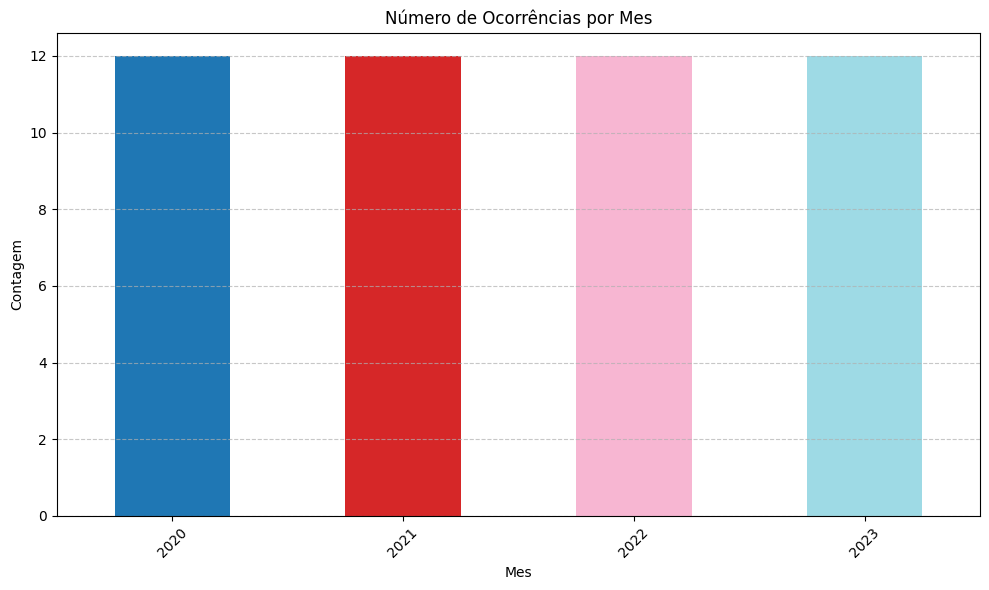

In [23]:
grafico_contagem(df, "Mes")

In [25]:
df.to_csv("data_Semiconfinado.csv", index=False)

# Treinamento LSTM

### Bibliotecas e funções basicas (executar primeiro)

In [26]:
%%capture
%pip install neuralforecast statsforecast
%pip install dask[dataframe]

In [27]:
import pandas as pd
import numpy as np

def wmape(y_true, y_pred):
  return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

In [28]:
import torch
from typing import Union

class WMAPE(torch.nn.Module):

  def __init__(self):
    super(WMAPE, self).__init__()
    self.outputsize_multiplier = 1
    self.output_names = [""]
    self.is_distribution_output = False

  def domain_map(self, y_hat: torch.Tensor):
    return y_hat.squeeze(-1)

  def __call__(
    self,
    y: torch.Tensor,
    y_hat: torch.Tensor,
    mask: Union[torch.Tensor, None] = None,
  ):
    if mask is None:
      mask = torch.ones_like(y_hat)

    num = mask * (y - y_hat).abs()
    den = mask * y.abs()
    return num.sum() / den.sum()

In [29]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_forecast_series(train_data, test_data, predictions, series_id=None):
  """
  Plota as séries temporais históricas, dados reais do teste e previsões com alinhamento temporal correto.

  Parâmetros:
  train_data: DataFrame com dados históricos de treino (até dez/2022)
  test_data: DataFrame com dados reais do período de teste (jan/2023 em diante)
  predictions: DataFrame com as previsões (começando em jan/2023)
  series_id: ID específico para plotar (opcional - se None, plota todas as séries)
  """
  # Se não especificou série, pega todas únicas do treino
  if series_id is None:
    series_ids = train_data['unique_id'].unique()
  else:
    series_ids = [series_id]

  # Cria subplots para cada série
  fig = make_subplots(
      rows=len(series_ids),
      cols=1,
      subplot_titles=[f'Série: {sid}' for sid in series_ids],
      vertical_spacing=0.1
  )

  # Para cada série
  for idx, sid in enumerate(series_ids, 1):
    # Dados históricos de treino (até dezembro/2022)
    hist_data = train_data[train_data['unique_id'] == sid]

    # Dados reais do período de teste (começa em janeiro/2023)
    test_data_series = test_data[test_data['unique_id'] == sid]

    # Previsões (começando em janeiro/2023)
    pred_data = predictions[predictions['unique_id'] == sid]
    # Ajusta para começar em janeiro/2023
    pred_data = pred_data[pred_data['ds'] >= '2023-01-01']

    # Adiciona linha histórica (treino)
    fig.add_trace(
      go.Scatter(
        x=hist_data['ds'],
        y=hist_data['y'],
        name='Dados Históricos (2019-2022)',
        line=dict(color='blue'),
        showlegend=True if idx == 1 else False
      ),
      row=idx,
      col=1
    )

    # Adiciona linha dos dados reais do teste
    fig.add_trace(
      go.Scatter(
        x=test_data_series['ds'],
        y=test_data_series['y'],
        name='Dados Reais (2023-2024)',
        line=dict(color='green'),
        showlegend=True if idx == 1 else False
      ),
      row=idx,
      col=1
    )

    # Adiciona linha de previsão
    fig.add_trace(
      go.Scatter(
        x=pred_data['ds'],
        y=pred_data['LSTM'],
        name='Previsão (2023-2024)',
        line=dict(color='red', dash='dash'),
        showlegend=True if idx == 1 else False
      ),
      row=idx,
      col=1
    )

    # Adiciona linha vertical separando treino e teste
    fig.add_vline(
      x='2023-01-01',  # Linha exatamente em janeiro/2023
      line_dash="dash",
      line_color="gray",
      opacity=0.5,
      row=idx,
      col=1
    )

  # Atualiza layout
  fig.update_layout(
    height=500 * len(series_ids),
    title_text="Comparação: Dados Históricos, Reais e Previsões",
    showlegend=True,
    template='plotly_white'
  )

  # Atualiza eixos
  fig.update_xaxes(title_text="Data", row=len(series_ids))
  fig.update_yaxes(title_text="Valor")

  return fig

### Preprocessamento Dataset

In [30]:
import pandas as pd

# Carregar os dois dataframes
df = pd.read_csv("/content/data_Semiconfinado.csv")

df['Mes'] = df['Mes'].astype('datetime64[ns]')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   CodFazenda   48 non-null     object        
 1   Mes          48 non-null     datetime64[ns]
 2   Secagens_10  48 non-null     int64         
 3   Secagens_11  48 non-null     int64         
 4   Secagens_12  48 non-null     int64         
 5   Secagens_13  48 non-null     int64         
 6   Secagens_14  48 non-null     int64         
 7   Secagens_15  48 non-null     int64         
 8   Nascimento   48 non-null     int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 3.5+ KB


In [32]:
# Renomear as colunas
df = df.rename(columns={
  'Mes': 'ds',
  'Nascimento': 'y',
  'CodFazenda': 'unique_id'
})

In [33]:
def standardize_dates(df, use_end_of_month=False):
  """
  Padroniza as datas para início ou fim do mês.

  Parameters:
  -----------
  df : pd.DataFrame
    DataFrame com coluna 'ds' contendo as datas
  use_end_of_month : bool
    Se True, usa último dia do mês. Se False, usa primeiro dia do mês.

  Returns:
  --------
  pd.DataFrame
    DataFrame com datas padronizadas
  """
  df = df.copy()

  if use_end_of_month:
      # Converte para último dia do mês
      df['ds'] = df['ds'].dt.to_period('M').dt.to_timestamp(how='end')
  else:
      # Converte para primeiro dia do mês
      df['ds'] = df['ds'].dt.to_period('M').dt.to_timestamp(how='start')

  return df

df = standardize_dates(df, use_end_of_month=False)

In [45]:
# Filtrar o DataFrame para datas até 2022-12-01
train_df = df[df['ds'] <= '2022-12-01']
# Filtrar o DataFrame para datas a partir de 2023-01-01
test_df = df[df['ds'] >= '2023-01-01']

print(f"DataFrame de treino: {len(train_df)} registros")
print(f"DataFrame de teste: {len(test_df)} registros")

DataFrame de treino: 36 registros
DataFrame de teste: 12 registros


### Ajuste de Hiperparametros

In [ ]:
# Faço depois

### Treinamento Modelo com os melhores parametros

In [36]:
h = test_df['ds'].nunique()
print(h)

best_config = {'h': h,
 'encoder_hidden_size': 200,
 'encoder_n_layers': 10,
 'context_size': 36,
 'decoder_hidden_size': 128,
 'learning_rate': 0.0015887770515036423,
 'max_steps': 500,
 'batch_size': 128,
 'loss': WMAPE(),
 'check_val_every_n_epoch': 100,
 'random_seed': 13,
 'input_size': 5760}

12


In [37]:
%%time
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM

models = [LSTM(scaler_type='robust',
               futr_exog_list=['Secagens_10', 'Secagens_11', 'Secagens_12', 'Secagens_13', 'Secagens_14', 'Secagens_15'],
               **best_config)]

model = NeuralForecast(models=models, freq='MS') # MS Month Start (primeiro dia do mês) e ME Month End (último dia do mês)
model.fit(train_df)

INFO:lightning_fabric.utilities.seed:Seed set to 13
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | WMAPE         | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 3.1 M  | train
4 | context_adapter | Linear        | 117 K  | train
5 | mlp_decoder     | MLP           | 5.6 K  | train
----------------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.721    Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


CPU times: user 1min 15s, sys: 3.52 s, total: 1min 18s
Wall time: 2min 13s


In [38]:
predictions = model.predict(futr_df=test_df)
predictions = predictions.merge(test_df[['ds','unique_id', 'y']], on=['ds', 'unique_id'], how='left')
predictions.head()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,unique_id,LSTM,y
0,2023-01-01,B4F72C4A-AB0F-44B4-BDF4-A44500F1C3E8,2.358386,2
1,2023-02-01,B4F72C4A-AB0F-44B4-BDF4-A44500F1C3E8,2.249073,2
2,2023-03-01,B4F72C4A-AB0F-44B4-BDF4-A44500F1C3E8,2.496897,2
3,2023-04-01,B4F72C4A-AB0F-44B4-BDF4-A44500F1C3E8,2.511764,3
4,2023-05-01,B4F72C4A-AB0F-44B4-BDF4-A44500F1C3E8,2.895984,3


In [39]:
import numpy as np

# Defina a opção de arredondamento
#rounding_option = 'floor'   # Parte inteira, ignora decimais (ex: 2.0514 >> 2)
rounding_option = 'nearest'  # Valor inteiro mais próximo (ex: 2.0514 >> 2, 2.5 >> 3)

# Aplica o arredondamento aos valores preditos
if rounding_option == 'floor':
    predictions['LSTM'] = np.floor(predictions['LSTM']).astype(int)
elif rounding_option == 'nearest':
    predictions['LSTM'] = np.rint(predictions['LSTM']).astype(int)

# Exibe uma amostra para verificar
print(predictions[['ds', 'unique_id', 'LSTM', 'y']].head())


          ds                             unique_id  LSTM  y
0 2023-01-01  B4F72C4A-AB0F-44B4-BDF4-A44500F1C3E8     2  2
1 2023-02-01  B4F72C4A-AB0F-44B4-BDF4-A44500F1C3E8     2  2
2 2023-03-01  B4F72C4A-AB0F-44B4-BDF4-A44500F1C3E8     2  2
3 2023-04-01  B4F72C4A-AB0F-44B4-BDF4-A44500F1C3E8     3  3
4 2023-05-01  B4F72C4A-AB0F-44B4-BDF4-A44500F1C3E8     3  3


In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime
import pandas as pd
import numpy as np

metrics_list = []
current_date = datetime.now().strftime('%Y-%m-%d')

for ID in predictions["unique_id"].unique():
  # Calcula as métricas de erro
  mse = mean_squared_error(predictions['y'], predictions['LSTM'])
  mae = mean_absolute_error(predictions['y'], predictions['LSTM'])
  rmse = np.sqrt(mse)
  r2 = r2_score(predictions['y'], predictions['LSTM'])

  metrics_list.append({
    'ID': ID,
    'MSE': mse,
    'MAE': mae,
    'RMSE': rmse,
    'R2': r2,
    'Date': current_date,
  })

  # Exibe os resultados
  print(f"ID: {ID} :: MSE: {mse:.8f}, MAE: {mae:.8f}, RMSE: {rmse:.8f}, R2: {r2:.8f}") # cenário perfeito MSE: 0, MAE: 0, RMSE: 0, R2: 1

# Converte a lista de métricas em um DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Salva o DataFrame em um arquivo CSV
metrics_df.to_csv(f"metricas_produtores_{datetime.now().strftime('%Y_%m_%d')}.csv", index=False)

ID: B4F72C4A-AB0F-44B4-BDF4-A44500F1C3E8 :: MSE: 0.25000000, MAE: 0.25000000, RMSE: 0.50000000, R2: 0.40000000


In [44]:
mostrar_todas = False

if mostrar_todas:
  # Para plotar todas as séries:
  for ID_DA_SERIE in predictions["unique_id"].unique():
    fig = plot_forecast_series(train_df, test_df, predictions, series_id=ID_DA_SERIE)
    fig.show()
else:
  # Para plotar apenas a primeira série
  ID_DA_SERIE = predictions["unique_id"][0]
  fig = plot_forecast_series(train_df, test_df, predictions, series_id=ID_DA_SERIE)
  fig.show()

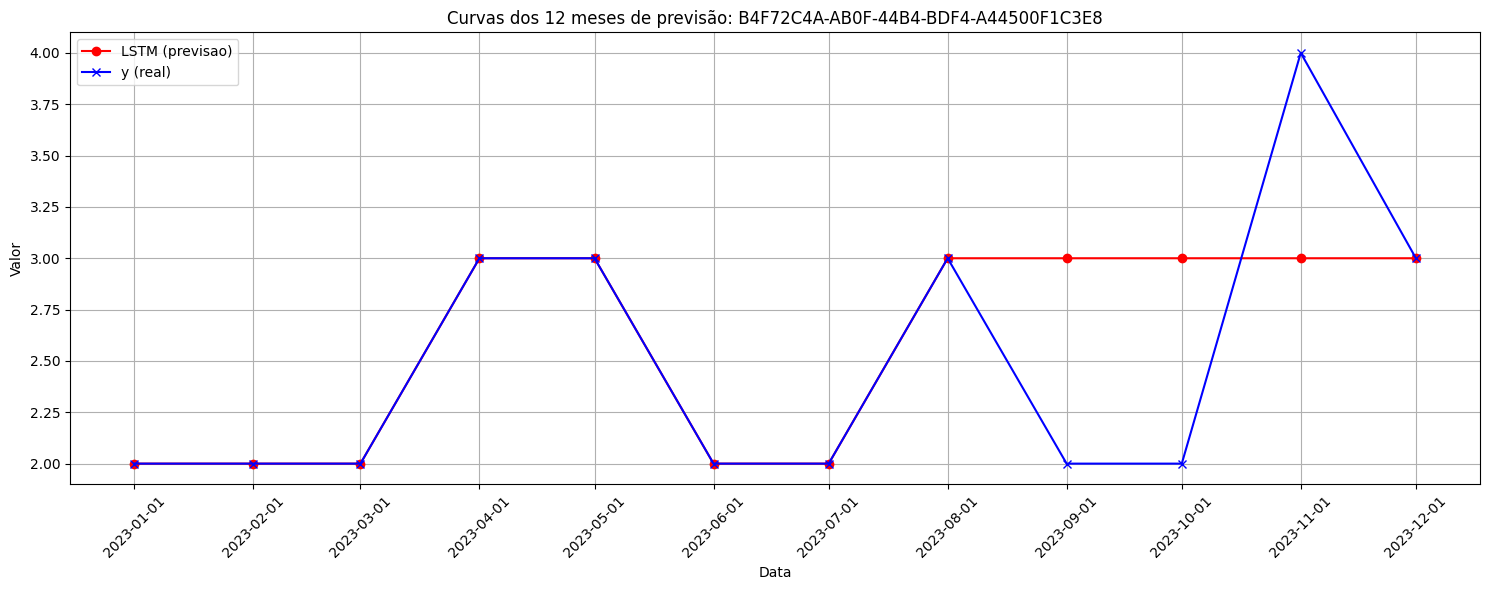

In [41]:
import matplotlib.pyplot as plt

for ID in predictions['unique_id'].unique():
  # Filtra as previsões para o ID específico
  predictions_id = predictions[predictions['unique_id'] == ID]

  # Plotando o gráfico
  plt.figure(figsize=(15, 6))
  plt.plot(predictions_id['ds'], predictions_id['LSTM'], label='LSTM (previsao)', color="red", marker='o')
  plt.plot(predictions_id['ds'], predictions_id['y'], label='y (real)', color="blue", marker='x')

  # Adicionando título e rótulos
  plt.title(f"Curvas dos 12 meses de previsão: {ID}")
  plt.xlabel('Data')
  plt.ylabel('Valor')
  plt.legend()

  # Exibindo todas as datas no eixo x
  plt.xticks(predictions_id['ds'], rotation=45)
  plt.grid(True)
  plt.tight_layout()

  # Exibindo o gráfico
  plt.show()
